In [41]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey, Float
from sqlalchemy.orm import sessionmaker, relationship, declarative_base
from langchain_core.runnables.config import RunnableConfig
from azure.identity import DefaultAzureCredential
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from chromadb import PersistentClient
from chromadb.utils.embedding_functions import EmbeddingFunction
from transformers import AutoTokenizer, AutoModel


load_dotenv()

DATABASE_URL = os.getenv("DATABASE_URL", "sqlite:///example.db")
engine = create_engine(DATABASE_URL)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)

CHROMA_DB_DIR = "./chroma_db"
COLLECTION_NAME = "schema_embeddings"
EMBEDDING_MODEL_NAME = "BAAI/bge-m3"

Base = declarative_base()


# Definition of the Users table
class User(Base):
    __tablename__ = "users"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, index=True)
    age = Column(Integer)
    email = Column(String, unique=True, index=True)

    orders = relationship("Order", back_populates="user")

# Definition of the Food table
class Food(Base):
    __tablename__ = "food"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, unique=True, index=True)
    price = Column(Float)

    orders = relationship("Order", back_populates="food")

# Definition of the Orders table
class Order(Base):
    __tablename__ = "orders"

    id = Column(Integer, primary_key=True, index=True)
    food_id = Column(Integer, ForeignKey("food.id"))
    user_id = Column(Integer, ForeignKey("users.id"))

    user = relationship("User", back_populates="orders")
    food = relationship("Food", back_populates="orders")

## Functions for Agent

In [89]:
import os
from typing import List, Optional
from chromadb import PersistentClient
from dotenv import load_dotenv
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_openai import AzureChatOpenAI, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sqlalchemy import text, inspect
from langgraph.graph import StateGraph, END
import json
from langchain_core.prompts.chat import SystemMessage, HumanMessage
# Load environment variables
load_dotenv()

# Define the path to the ChromaDB directory
CHROMA_DB_DIR = os.getenv("CHROMA_DB_DIR", "chromadb")

class AgentState(TypedDict):
    question: str
    sql_query: Optional[str]
    query_result: Optional[str]
    query_rows: List[dict]
    current_user: str
    attempts: int
    relevance: str
    sql_error: bool
    context: List[str]
    chart_type: Optional[str]
    chart_title: Optional[str]
    schema_info: str
    database_description: str
    

MAX_RETRIES = 3



def get_database_schema(state: AgentState, config: dict):
    """
    Extracts relevant schema information and generates a database description.

    Args:
        state (AgentState): Current agent state containing the question.
        config (dict): Configuration dictionary.

    Returns:
        AgentState: Updated state with extracted schema information and a database description.
    """
    question = state["question"]

    # Retrieve relevant schema context using hybrid search
    context = hybrid_search(
        question,
        schema,  # Extracted database schema
        chroma_collection,
        embedding_model,
        graph,
        max_results=15  # Retrieve top 15 relevant elements
    )

    if not context:
        state["schema_info"] = ""
        state["database_description"] = ""
        print("[DEBUG] No relevant schema found.")
        return state

    # Extract schema information for relevant tables
    schema_info = ["### Relevant Schema Information"]
    relevant_tables = set()

    for node in context:
        try:
            node_type = graph.nodes[node]["type"]
            if node_type == "table":
                relevant_tables.add(node)
            elif node_type == "column":
                relevant_tables.add(graph.nodes[node]["table"])
        except KeyError:
            continue  # Skip invalid nodes

    # Generate structured schema details
    table_summaries = []
    for table in relevant_tables:
        table_metadata = graph.nodes[table]
        primary_keys = table_metadata.get("primary_keys", [])
        examples = table_metadata.get("examples", {})

        schema_info.append(f"\nTable: {table}")
        if primary_keys:
            schema_info.append(f"  - Primary Keys: {', '.join(primary_keys)}")
        if examples:
            schema_info.append(f"  - Examples: {examples}")

        # Summarize table for LLM description
        summary = f"Table '{table}' contains {len(graph[table])} columns."
        if primary_keys:
            summary += f" It has primary key(s): {', '.join(primary_keys)}."
        if examples:
            summary += f" Example values include: {', '.join(map(str, list(examples.values())[:3]))}."
        table_summaries.append(summary)

        # Add column details
        for neighbor in graph.neighbors(table):
            try:
                if graph.nodes[neighbor]["type"] == "column":
                    column_metadata = graph.nodes[neighbor]
                    column_name = neighbor.split(".")[1]
                    column_type = column_metadata["data_type"]
                    primary_key = column_metadata.get("primary_key", False)
                    column_examples = column_metadata.get("examples", [])

                    # Highlight relevant columns
                    if neighbor in context:
                        schema_info.append(
                            f"  - {column_name} ({column_type}) [RELEVANT] - "
                            f"{'Primary Key' if primary_key else ''} "
                            f"{f'Examples: {column_examples}' if column_examples else ''}"
                        )
                    else:
                        schema_info.append(
                            f"  - {column_name} ({column_type}) - "
                            f"{'Primary Key' if primary_key else ''} "
                            f"{f'Examples: {column_examples}' if column_examples else ''}"
                        )
            except KeyError:
                continue

    # Generate a human-readable database description using LLM
    system_prompt = f"""
    You are an expert in database systems. Given the extracted schema information below,
    provide a concise and informative 5-6 sentence description of the database.
    
    **Extracted Schema Information:**
    {'. '.join(table_summaries)}

    The description should be clear, mentioning the key tables, their purpose, and how they relate to each other.
    """
    
    llm = AzureChatOpenAI(
        temperature=0,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        openai_api_version=os.getenv("OPENAI_API_VERSION"),
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
    )

    response = llm([SystemMessage(content=system_prompt)])
    database_description = response.content.strip()

    # Store schema info and database description in state
    state["schema_info"] = "\n".join(schema_info)
    state["database_description"] = database_description

    # print(f"[DEBUG] Retrieved schema info successfully: {state['schema_info']}")
    if state['database_description'] == "":
        print("[DEBUG] No database description generated.")
        
    print(f"[DEBUG] Generated database description: {state['database_description']}")

    return state



class GetCurrentUser(BaseModel):
    current_user: str = Field(
        description="The name of the current user based on the provided user ID."
    )

def get_current_user(state: AgentState, config: RunnableConfig):
    print("Retrieving the current user based on user ID.")
    user_id = config["configurable"].get("current_user_id", None)
    if not user_id:
        state["current_user"] = "User not found"
        print("No user ID provided in the configuration.")
        return state

    session = SessionLocal()
    try:
        user = session.query(User).filter(User.id == int(user_id)).first()
        if user:
            state["current_user"] = user.name
            print(f"Current user set to: {state['current_user']}")
        else:
            state["current_user"] = "User not found"
            print("User not found in the database.")
    except Exception as e:
        state["current_user"] = "Error retrieving user"
        print(f"Error retrieving user: {str(e)}")
    finally:
        session.close()
    return state

class CheckRelevance(BaseModel):
    relevance: str = Field(
        description="Indicates whether the question is related to the database schema. 'relevant' or 'not_relevant'."
    )

from langchain_core.prompts.chat import ChatPromptTemplate
from langchain_openai import ChatOpenAI



class ConvertToSQL(BaseModel):
    sql_query: str = Field(
        description="The SQL query corresponding to the user's natural language question."
    )

# Convert Natural Language to SQL

def convert_nl_to_sql(state: AgentState):
    """
    Convert user question into an SQL query using extracted schema.
    """
    question = state["question"]
    schema_info = state.get("schema_info", "")
    data_description = state.get("database_description", "")

    if not schema_info:
        state["sql_query"] = ""
        print("[DEBUG] No schema info available.")
        return state

    system_prompt = f"""
    Convert the question into an SQL query using this schema:

    Question: {question}
    Database Schema: {schema_info}
    Database Description: {data_description}
    user_id: {state.get("current_user_id", "None")}
    """

    llm = AzureChatOpenAI(
        temperature=0,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        openai_api_version=os.getenv("OPENAI_API_VERSION"),
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
    )

    response = llm([SystemMessage(content=system_prompt)])
    response_content = response.content.strip()

    # Debugging
    print("Raw LLM Response Content:", response_content)

    # Remove SQL formatting artifacts
    if response_content.startswith("```sql") and response_content.endswith("```"):
        response_content = response_content[6:-3].strip()

    print("Cleaned LLM Response Content:", response_content)
    
    # Store SQL query in state
    state["sql_query"] = response_content
    return state


def execute_sql(state: AgentState) -> AgentState:
    """Execute SQL query with safety checks"""
    print("[DEBUG] Executing SQL query")
    session = SessionLocal()
    state["sql_error"] = False
    
    try:
        if not state["sql_query"] or not state["sql_query"].lower().startswith("select"):
            raise ValueError("Only SELECT queries are allowed")
            
        result = session.execute(text(state["sql_query"]))
        
        if "select" in state["sql_query"].lower():
            columns = result.keys()
            rows = [dict(zip(columns, row)) for row in result.fetchall()]
            state.update({
                "query_rows": rows,
                "query_result": f"Retrieved {len(rows)} records"
            })
        else:
            session.commit()
            state["query_result"] = "Operation completed successfully"
            
    except Exception as e:
        state.update({
            "sql_error": True,
            "query_result": f"SQL Error: {str(e)}"
        })
    finally:
        session.close()
    
    print("[DEBUG] SQL execution result:", state["query_result"])
    return state


def regenerate_query(state: AgentState):
    """
    Reformulates the user's question to make it SQL-compatible based on database schema,
    previous SQL errors, and LLM-driven refinement.
    """
    if state["attempts"] >= MAX_RETRIES:
        state["query_result"] = "Max retries reached. Unable to process your request."
        state["sql_query"] = None  # Prevent further execution
        return state

    question = state["question"]
    database_description = state.get("database_description", "No database description available.")
    schema_info = state.get("schema_info", "No schema info available.")
    previous_sql_error = state.get("query_result", "")

    # Generate a structured prompt to reformulate the question
    system_prompt = f"""
    You are an expert in SQL and database systems. Your task is to refine the following natural language question
    to ensure it is clear, precise, and SQL-compatible.

    **Database Context:**
    {database_description}

    **Schema Details:**
    {schema_info}

    **User's Original Question:**
    "{question}"

    **Previous SQL Issue (if any):**
    {previous_sql_error}

    Please reformulate the question while keeping the original intent, ensuring it is properly structured
    for conversion into a valid SQL query. The output should be **only** the refined question, without any explanations.
    """

    llm = AzureChatOpenAI(
        temperature=0,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        openai_api_version=os.getenv("OPENAI_API_VERSION"),
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME"),
    )

    response = llm([SystemMessage(content=system_prompt)])
    refined_question = response.content.strip()

    # Store the refined question and update attempts
    state["question"] = refined_question
    state["attempts"] += 1

    print(f"[DEBUG] Refined Question (Attempt {state['attempts']}): {refined_question}")

    return state




def generate_human_readable_answer(state: AgentState) -> AgentState:
    """Generate a natural language response using LLM for query explanation and context."""
    print("[DEBUG] Generating human-readable answer with LLM")

    components = {
        "user": state.get("current_user", "User"),
        "error": state.get("sql_error", False),
        "result": state.get("query_result", ""),
        "rows": state.get("query_rows", []),
        "chart_type": state.get("chart_type"),
        "chart_title": state.get("chart_title"),
        "sql_query": state.get("sql_query", ""),
        "database_description": state.get("database_description", "This database contains structured information relevant to your queries.")
    }

    # Define base message
    base_message = f"Hello {components['user']}, "

    # Error Handling
    if components["error"]:
        error_message = (
            f"there was an error executing your query.\n\n"
            f"🔴 **Error Details:** {components['result']}\n\n"
            "Possible reasons:\n"
            "- The table or column you requested might not exist.\n"
            "- There could be a syntax issue in the generated SQL query.\n"
            "- Database connectivity issues.\n\n"
            "📌 Try rephrasing your question or ensuring the data exists."
        )
        state["query_result"] = base_message + error_message
        return state

    # LLM Prompt to Generate Natural Language Response
    system_prompt = f"""
    You are an expert data analyst. Your task is to explain the results of a SQL query to a user in simple, insightful, and informative language.
    
    ** User's question:**
    {state['question']}
    
    **Database Context:**  
    {components['database_description']}
    
    **SQL Query Executed:**  
    ```sql
    {components['sql_query']}
    ```

    **Query Execution Result:**  
    {components['result']}

    **Scenario Handling:**  
    - If the query returned a dataset, provide a **summary of the results**, highlight key findings, and mention potential insights.  
    - If a chart was generated, explain what it represents and its significance.  
    - If no data was found, suggest possible reasons and alternative queries.  
    - Avoid using overly technical SQL terms—keep it user-friendly.

    **User-Friendly Response Format:**  
    - Start with a **greeting and summary**.  
    - Provide an **overview of the query results**.  
    - Offer **insights or trends** based on the data.  
    - End with a **call to action or next steps**.
    """

    # LLM API Call
    llm = AzureChatOpenAI(
        temperature=0.5,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        openai_api_version=os.getenv("OPENAI_API_VERSION"),
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
    )

    # Human input message (contextualizing response)
    human_message = f"Here is the retrieved data: {components['rows'][:5]}"

    response = llm.invoke([SystemMessage(content=system_prompt), HumanMessage(content=human_message)])

    # Store final response in state
    state["query_result"] = response.content.strip()

    print("[DEBUG] Generated Human-Readable Explanation:", state["query_result"])
    return state




class RewrittenQuestion(BaseModel):
    question: str = Field(description="The rewritten question.")



def generate_funny_response(state: AgentState):
    print("Generating a funny response for an unrelated question.")
    system = """You are a charming and funny assistant who responds in a playful manner.
    """
    human_message = "I can not help with that, but doesn't asking questions make you hungry? You can always order something delicious."
    funny_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human_message),
        ]
    )
    llm = AzureChatOpenAI(
        temperature=0.8,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        openai_api_version=os.getenv("OPENAI_API_VERSION"),
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
    )

    funny_response = funny_prompt | llm | StrOutputParser()
    message = funny_response.invoke({})
    state["query_result"] = message
    print("Generated funny response.")
    return state

def end_max_iterations(state: AgentState):
    state["query_result"] = "Please try again."
    print("Maximum attempts reached. Ending the workflow.")
    return state

def relevance_router(state: AgentState):
    relevance = state.get("relevance", "").lower()
    if relevance == "relevant":
        return "retrieve_context" 
    else:
        return "generate_funny_response"


def check_attempts_router(state: AgentState):
    attempts = state.get("attempts", 0)
    if attempts < 10:
        return "convert_nl_to_sql"
    else:
        return "end_max_iterations"


def execute_sql_router(state: AgentState):
    if state.get("sql_query") is None or state.get("sql_error", False):
        if state["attempts"] >= MAX_RETRIES:
            return "end_max_iterations"
        return "regenerate_query"
    elif state.get("query_rows"):
        return "generate_visualization"
    else:
        return "generate_human_readable_answer"


    
def merge_question_updates(state):
    """
    Consolidates updates to the 'question' key.
    """
    state["merged_question"] = state.get("question", "")
    return state







In [70]:
from typing import Dict, List
import torch



class ThaiBGEEmbeddingFunction(EmbeddingFunction):
    """
    Embedding function with proper pooling and Thai language support
    """
    def __init__(self, model_name= "BAAI/bge-m3"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.eval()  # Disable dropout for evaluation

    def __call__(self, texts: List[str]) -> List[List[float]]:
        """
        Generate embeddings for input texts
        Args:
            texts (List[str]): List of strings to embed
        Returns:
            List[List[float]]: List of embeddings
        """
        if isinstance(texts, str):  # Ensure input is a list
            texts = [texts]
        
        inputs = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=512
        )
        with torch.no_grad():
            outputs = self.model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0]  # CLS pooling
        return embeddings.cpu().numpy().tolist()

def process_schema_to_graph_and_embeddings(schema: Dict, chroma_collection, embedding_model) -> nx.DiGraph:
    """
    Process database schema into a graph structure and store embeddings in ChromaDB,
    using M-Schema format for enhanced metadata.
    """
    graph = nx.DiGraph()
    entries = []

    for table_name, details in schema.items():
        # Add table as a node with enriched metadata
        graph.add_node(
            table_name,
            type="table",
            description=details.get("description", ""),
            primary_keys=details.get("primary_keys", []),
            examples=details.get("examples", {})
        )

        # Process columns with M-Schema metadata
        for column in details["columns"]:
            column_id = f"{table_name}.{column['name']}"
            
            # Safely get examples for the column and serialize them
            examples = column.get("examples", [])
            examples_serialized = ", ".join(map(str, examples)) if examples else "None"
            
            graph.add_node(
                column_id,
                type="column",
                table=table_name,
                data_type=column["type"],
                primary_key=column.get("primary_key", False),
                examples=examples_serialized  # Store serialized examples
            )
            graph.add_edge(table_name, column_id, relation="has_column")

            # Add column embedding entry
            column_text = (
                f"Column: {column['name']} ({column['type']}), "
                f"Primary Key: {column.get('primary_key', False)}, "
                f"Examples: {examples_serialized}"
            )
            embedding = embedding_model([column_text])[0]

            entries.append({
                "id": column_id,
                "text": column_text,
                "embedding": embedding,
                "metadata": {
                    "type": "column",
                    "table": table_name,
                    "data_type": column["type"],
                    "primary_key": column.get("primary_key", False),
                    "examples": examples_serialized  # Store serialized examples in metadata
                }
            })

        # Process relationships with enriched metadata
        for relation in details.get("relationships", []):
            rel_id = f"{table_name}.{relation['source_column']}->{relation['target_table']}.{relation['target_column']}"
            
            graph.add_edge(
                table_name,
                relation["target_table"],
                relation="foreign_key",
                source_column=relation["source_column"],
                target_column=relation["target_column"]
            )
            
            # Relationship text for embeddings
            rel_text = (
                f"Foreign Key: {table_name}.{relation['source_column']} → "
                f"{relation['target_table']}.{relation['target_column']}, "
                f"Maps to: {relation.get('maps_to', '')}"
            )
            embedding = embedding_model([rel_text])[0]

            entries.append({
                "id": rel_id,
                "text": rel_text,
                "embedding": embedding,
                "metadata": {
                    "type": "relationship",
                    "source_table": table_name,
                    "source_column": relation["source_column"],
                    "target_table": relation["target_table"],
                    "target_column": relation["target_column"],
                    "maps_to": relation.get("maps_to", "")
                }
            })

    # Debug: Print sample metadata for verification
    if entries:
        print(f"Sample Metadata Entry: {entries[0]['metadata']}")

    # Store embeddings in ChromaDB
    if entries:
        chroma_collection.add(
            ids=[entry["id"] for entry in entries],
            documents=[entry["text"] for entry in entries],
            embeddings=[entry["embedding"] for entry in entries],
            metadatas=[entry["metadata"] for entry in entries]
        )
    
    return graph


# -------------------------- ENHANCED RETRIEVAL ------------------------- #
def retrieve_context(state: AgentState):
    state["context"] = hybrid_search(
        state["question"],
        schema,
        chroma_collection,
        embedding_model,
        graph,
        max_results=15
    )
    return state


from sqlalchemy.sql import text  # Import text for raw SQL queries

def extract_database_schema(engine):
    inspector = inspect(engine)
    schema = {}

    # Create a connection for executing SQL queries
    with engine.connect() as connection:
        tables = inspector.get_table_names()

        for table_name in tables:
            schema[table_name] = {"columns": [], "relationships": [], "examples": {}}
            
            # Extract columns
            columns = inspector.get_columns(table_name)
            for column in columns:
                # Add column details with examples
                examples = []  # Retrieve examples from the database
                try:
                    # Use sqlalchemy.text to create a valid SQL query object
                    query = text(f"SELECT {column['name']} FROM {table_name} LIMIT 3")
                    examples = [row[0] for row in connection.execute(query).fetchall()]
                except Exception as e:
                    print(f"Failed to fetch examples for {table_name}.{column['name']}: {e}")
                
                schema[table_name]["columns"].append({
                    "name": column["name"],
                    "type": str(column["type"]).split("(")[0],
                    "examples": examples
                })

            # Extract foreign keys
            foreign_keys = inspector.get_foreign_keys(table_name)
            for fk in foreign_keys:
                schema[table_name]["relationships"].append({
                    "source_column": fk["constrained_columns"][0],
                    "target_table": fk["referred_table"],
                    "target_column": fk["referred_columns"][0]
                })

    return schema

def keyword_search(query: str, schema: Dict) -> List[str]:
    """
    Perform keyword search to find schema elements directly matching query keywords.
    Args:
        query (str): User's natural language query.
        schema (Dict): Extracted database schema.
    Returns:
        List[str]: List of schema elements matching the query keywords.
    """
    keywords = query.lower().split()  # Split the query into individual words
    matches = []

    for table, details in schema.items():
        # Match table names
        if any(keyword in table.lower() for keyword in keywords):
            matches.append(table)

        # Match column names
        for column in details["columns"]:
            if any(keyword in column["name"].lower() for keyword in keywords):
                matches.append(f"{table}.{column['name']}")

    return matches



def semantic_search(query: str, chroma_collection, embedding_model, max_results: int = 20) -> List[str]:
    """
    Perform semantic search to retrieve schema elements based on embeddings.
    Args:
        query (str): User's natural language query.
        chroma_collection: ChromaDB collection.
        embedding_model: Embedding model for generating embeddings.
        max_results (int): Maximum number of results to return.
    Returns:
        List[str]: List of schema elements matching the query semantically.
    """
    # Generate embedding for the query
    query_embedding = embedding_model([query])[0]
    
    # Query ChromaDB
    results = chroma_collection.query(query_embeddings=[query_embedding], n_results=max_results)
    
    # Extract IDs of matching schema elements
    return results["ids"][0]


def hybrid_search(
    query: str,
    schema: Dict,
    chroma_collection,
    embedding_model,
    graph: nx.DiGraph,
    max_results: int = 20
) -> List[str]:
    """
    Combine keyword search and semantic search for hybrid retrieval.
    Args:
        query (str): User's natural language query.
        schema (Dict): Extracted database schema.
        chroma_collection: ChromaDB collection.
        embedding_model: Embedding model for generating embeddings.
        max_results (int): Maximum number of results to return.
    Returns:
        List[str]: Combined results from keyword and semantic search.
    """
    # Perform keyword search
    keyword_matches = keyword_search(query, schema)

    # Perform semantic search
    semantic_matches = semantic_search(query, chroma_collection, embedding_model, max_results)

    # Combine and deduplicate results
    combined_matches = list(set(keyword_matches + semantic_matches))

    # Limit results to max_results
    return combined_matches[:max_results]


def assemble_prompt(query: str, context: List[str], graph: nx.DiGraph) -> str:
    """
    Build a structured and optimized prompt with schema context, highlighting relevant parts
    and including enriched metadata like examples and primary keys.
    """
    prompt_lines = [
        "### Task",
        "Translate the following natural language query into an SQL query:",
        "",
        f"### Query\n{query}",
        "",
        "### Relevant Schema Information"
    ]

    # Collect relevant tables and their metadata
    relevant_tables = set()
    for node in context:
        try:
            if graph.nodes[node]["type"] == "table":
                relevant_tables.add(node)
            elif graph.nodes[node]["type"] == "column":
                relevant_tables.add(graph.nodes[node]["table"])
        except KeyError:
            continue  # Skip nodes that lack necessary attributes

    # Add details for relevant tables and columns
    for table in relevant_tables:
        table_metadata = graph.nodes[table]
        primary_keys = table_metadata.get("primary_keys", [])
        examples = table_metadata.get("examples", {})
        prompt_lines.append(f"\nTable: {table}")
        if primary_keys:
            prompt_lines.append(f"  - Primary Keys: {', '.join(primary_keys)}")
        if examples:
            prompt_lines.append(f"  - Examples: {examples}")

        # Add column details
        for neighbor in graph.neighbors(table):
            try:
                if graph.nodes[neighbor]["type"] == "column":
                    column_metadata = graph.nodes[neighbor]
                    column_name = neighbor.split(".")[1]
                    column_type = column_metadata["data_type"]
                    primary_key = column_metadata.get("primary_key", False)
                    column_examples = column_metadata.get("examples", [])

                    # Highlight relevant columns
                    if neighbor in context:
                        prompt_lines.append(
                            f"  - {column_name} ({column_type}) [RELEVANT] - "
                            f"{'Primary Key' if primary_key else ''} "
                            f"{f'Examples: {column_examples}' if column_examples else ''}"
                        )
                    else:
                        prompt_lines.append(
                            f"  - {column_name} ({column_type}) - "
                            f"{'Primary Key' if primary_key else ''} "
                            f"{f'Examples: {column_examples}' if column_examples else ''}"
                        )
            except KeyError:
                continue

    # Add relevant relationships
    prompt_lines.append("\n### Relationships")
    for edge in graph.edges(data=True):
        if edge[2].get("relation") == "foreign_key":
            source = edge[0]
            target = edge[1]
            source_col = edge[2]["source_column"]
            target_col = edge[2]["target_column"]
            maps_to = edge[2].get("maps_to", "")
            relationship_examples = edge[2].get("examples", [])
            if source in relevant_tables or target in relevant_tables:
                prompt_lines.append(
                    f"  - {source} ({source_col}) → {target} ({target_col}) [RELEVANT] "
                    f"{f'Maps to: {maps_to}' if maps_to else ''} "
                    f"{f'Examples: {relationship_examples}' if relationship_examples else ''}"
                )

    # Final instructions
    prompt_lines.append("\n### SQL Query")
    prompt_lines.append("-- Write the SQL query below this line --")
    print(f"Assemble Prompt: {prompt_lines}")
    return "\n".join(prompt_lines)


COLLECTION_NAME = 'schema_embeddings'

def setup_chroma_db():
    """
    Initialize ChromaDB and ensure collection matches embedding dimension
    """
    schema = extract_database_schema(engine)
    
    chroma_client = PersistentClient(path=CHROMA_DB_DIR)
    try:
        # Try to get the collection
        collection = chroma_client.get_collection(COLLECTION_NAME)
    except Exception:
        # Create collection with correct embedding function and dimension
        collection = chroma_client.create_collection(
            name=COLLECTION_NAME,
            embedding_function=ThaiBGEEmbeddingFunction()
        )
    return chroma_client, collection



schema = extract_database_schema(engine)
chroma_client, chroma_collection = setup_chroma_db()
embedding_model = ThaiBGEEmbeddingFunction()
graph = process_schema_to_graph_and_embeddings(schema, chroma_collection, embedding_model)


Add of existing embedding ID: coupons.id
Add of existing embedding ID: coupons.code
Add of existing embedding ID: coupons.discount_percentage
Add of existing embedding ID: coupons.expiration_date
Add of existing embedding ID: discounts.id
Add of existing embedding ID: discounts.food_id
Add of existing embedding ID: discounts.discount_percentage
Add of existing embedding ID: discounts.food_id->food.id
Add of existing embedding ID: employees.id
Add of existing embedding ID: employees.name
Add of existing embedding ID: employees.position
Add of existing embedding ID: employees.salary
Add of existing embedding ID: food.id
Add of existing embedding ID: food.name
Add of existing embedding ID: food.price
Add of existing embedding ID: food_category.id
Add of existing embedding ID: food_category.name
Add of existing embedding ID: food_category_mapping.id
Add of existing embedding ID: food_category_mapping.food_id
Add of existing embedding ID: food_category_mapping.category_id
Add of existing em

Sample Metadata Entry: {'type': 'column', 'table': 'coupons', 'data_type': 'INTEGER', 'primary_key': False, 'examples': '3, 4, 9'}


In [ ]:

from langchain_core.prompts.chat import ChatPromptTemplate

def check_relevance(state: AgentState, config: dict):
    """
    Determine if the user's question is relevant to the database schema.
    
    Args:
        state (AgentState): Current agent state containing the question and schema info.
        config (dict): Configuration dictionary.

    Returns:
        AgentState: Updated state with relevance determination.
    """
    question = state["question"]
    schema_info = state["schema_info"]  # Use the extracted schema from get_database_schema
    data_description = state["database_description"]

    if not schema_info:
        state["relevance"] = "not_relevant"
        print("[DEBUG] No relevant schema context found. Marking as not relevant.")
        return state

    print(f"[DEBUG] Using extracted schema info: {schema_info[:500]}")  # Print first 500 characters for debugging

    # Construct prompt with extracted schema context
    system_prompt = f"""
    You are an AI assistant that determines if a given question is related to a database schema.

    - If the question is **clearly related** to the database (queries about data, tables, or relationships), respond `"relevant"`.
    - If the question is **unrelated** (about the weather, general facts, jokes, etc.), respond `"not_relevant"`.

    **Database Schema Context:**
    {schema_info}

    **Database Description:**
    {data_description}

    **User Question:**
    {question}
    """

    # LLM call to determine relevance
    llm = AzureChatOpenAI(
        temperature=0,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        openai_api_version=os.getenv("OPENAI_API_VERSION"),
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
    )

    response = llm([SystemMessage(content=system_prompt)])
    state["relevance"] = response.content.strip().lower()

    print(f"[DEBUG] LLM determined relevance as: {state['relevance']}")
    return state



## Debugging

In [ ]:
# i want assemble prompt only 
state = {
    "question": "Find all users who have ordered food, count total price of orders for each user",
    "relevance": "relevant"
}
state = assemble_prompt(state["question"], state["context"], graph)

In [15]:
state = {"question": "show me all coupons, and hilight minumum and maximum value", "sql_query": ""}
convert_nl_to_sql(state, engine)
print("Generated SQL:", state["sql_query"])


Retrieved database schema.
Raw LLM Response Content: ```sql
SELECT 
    code, 
    discount_percentage, 
    expiration_date,
    CASE 
        WHEN discount_percentage = (SELECT MIN(discount_percentage) FROM coupons) THEN 'Minimum Value'
        WHEN discount_percentage = (SELECT MAX(discount_percentage) FROM coupons) THEN 'Maximum Value'
        ELSE ''
    END AS value_status
FROM 
    coupons;
```
Cleaned LLM Response Content: SELECT 
    code, 
    discount_percentage, 
    expiration_date,
    CASE 
        WHEN discount_percentage = (SELECT MIN(discount_percentage) FROM coupons) THEN 'Minimum Value'
        WHEN discount_percentage = (SELECT MAX(discount_percentage) FROM coupons) THEN 'Maximum Value'
        ELSE ''
    END AS value_status
FROM 
    coupons;
Generated SQL: SELECT 
    code, 
    discount_percentage, 
    expiration_date,
    CASE 
        WHEN discount_percentage = (SELECT MIN(discount_percentage) FROM coupons) THEN 'Minimum Value'
        WHEN discount_percenta

In [5]:
state = {"sql_query": "SELECT * FROM coupons", "query_rows": [], "query_result": ""}
session = SessionLocal()
execute_sql(state, session)
print("Query Result:", state["query_result"])
print("Query Rows:", state["query_rows"])


[DEBUG] Raw Result: <sqlalchemy.engine.cursor.CursorResult object at 0x1059fd480>
[DEBUG] Rows: [(1, 'COUPONmBYy', 30.74, 1879459200000), (2, 'COUPONyLqw', 25.96, 1830816000000), (3, 'COUPONAmyC', 45.97, '2025-04-03'), (4, 'COUPONHrUX', 16.34, '2025-09-16'), (5, 'COUPONiozW', 9.92, '2025-08-25'), (6, 'COUPONvWwN', 16.96, '2025-06-27'), (7, 'COUPONPiTu', 9.9, '2025-02-18'), (8, 'COUPONUqyN', 21.92, '2025-05-03'), (9, 'COUPONOpbb', 8.87, '2025-08-15'), (10, 'COUPONVmFZ', 12.84, '2025-12-22')]
[DEBUG] Columns: RMKeyView(['id', 'code', 'discount_percentage', 'expiration_date'])
Query Result: Query executed successfully. Found 10 rows.
Query Rows: [{'id': 1, 'code': 'COUPONmBYy', 'discount_percentage': 30.74, 'expiration_date': 1879459200000}, {'id': 2, 'code': 'COUPONyLqw', 'discount_percentage': 25.96, 'expiration_date': 1830816000000}, {'id': 3, 'code': 'COUPONAmyC', 'discount_percentage': 45.97, 'expiration_date': '2025-04-03'}, {'id': 4, 'code': 'COUPONHrUX', 'discount_percentage': 16.

In [6]:
import os

state = {"question": "show me all orders", "sql_query": ""}
convert_nl_to_sql(state, engine)
print("Generated SQL:", state["sql_query"])

Retrieved database schema.
Raw LLM Response Content: ```sql
SELECT * FROM orders;
```
Cleaned LLM Response Content: SELECT * FROM orders;
Generated SQL: SELECT * FROM orders;


## Visualization

In [99]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pydantic import BaseModel, Field, ValidationError
from langchain.schema import SystemMessage, HumanMessage
from langchain_openai import AzureChatOpenAI

# ------------------------ Enhanced Visualization Components ------------------------ #

class VisualizationDetails(BaseModel):
    """Model to validate and store visualization details from LLM."""
    chart_type: str = Field(description="Type of chart (bar, pie, line, scatter, hist)")
    x_column: str = Field(description="Column for x-axis/labels")
    y_column: str = Field(description="Column for y-axis/values")
    hue: Optional[str] = Field(default=None, description="Column for color grouping (optional)")
    title: str = Field(description="Chart title")
    xlabel: Optional[str] = Field(default=None, description="Label for X-axis (optional)")
    ylabel: Optional[str] = Field(default=None, description="Label for Y-axis (optional)")
def generate_visualization(state: AgentState) -> AgentState:
    """Generate an advanced visualization from query results."""
    print("[DEBUG] Starting advanced visualization generation")

    query_rows = state.get("query_rows", [])
    if not query_rows:
        state["query_result"] = "No data available for visualization."
        return state

    try:
        df = pd.DataFrame(query_rows)
        if df.empty:
            raise ValueError("DataFrame is empty after loading query results.")

        # Request visualization recommendations from LLM
        system_msg = f"""Analyze this data and recommend an optimal visualization:
        - **Columns:** {list(df.columns)}
        - **First 3 rows:** {df.head(3).to_dict(orient='records')}
        - **User Question:** {state['question']}
        - **Response Format:** JSON with fields: chart_type, x_column, y_column, hue (optional), title, xlabel, ylabel"""

        llm = AzureChatOpenAI(
            temperature=0,
            azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
            api_key=os.getenv("OPENAI_API_KEY"),
            deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
        )

        response = llm.invoke([SystemMessage(content=system_msg)])
        print("[DEBUG] LLM Visualization Response:", response.content)

        # Parse and validate the LLM response
        response_content = response.content.strip("```json").strip("```").strip()
        vis_details = json.loads(response_content)

        # Ensure 'hue' is properly handled
        if "hue" not in vis_details or vis_details["hue"] is None:
            vis_details["hue"] = None  # Set to None explicitly

        validated = VisualizationDetails.model_validate(vis_details)
        state.update({
            "chart_type": validated.chart_type,
            "chart_title": validated.title
        })

        # Validate DataFrame columns
        if validated.x_column not in df.columns:
            raise ValueError(f"Missing x-axis column: {validated.x_column}")
        if validated.y_column not in df.columns:
            raise ValueError(f"Missing y-axis column: {validated.y_column}")

        # Set up plot styling
        plt.figure(figsize=(12, 7))
        sns.set_style("whitegrid")

        # Define visualization methods
        plot_methods = {
            "bar": lambda: sns.barplot(data=df, x=validated.x_column, y=validated.y_column, hue=validated.hue if validated.hue in df.columns else None),
            "pie": lambda: df.groupby(validated.x_column)[validated.y_column].sum().plot(kind="pie", autopct="%1.1f%%", startangle=90, figsize=(8, 8)),
            "line": lambda: sns.lineplot(data=df, x=validated.x_column, y=validated.y_column, hue=validated.hue if validated.hue in df.columns else None, marker="o"),
            "scatter": lambda: sns.scatterplot(data=df, x=validated.x_column, y=validated.y_column, hue=validated.hue if validated.hue in df.columns else None),
            "hist": lambda: sns.histplot(df[validated.y_column], kde=True, bins=15)
        }

        if validated.chart_type not in plot_methods:
            raise ValueError(f"Unsupported chart type: {validated.chart_type}")

        # Generate the selected chart
        plot_methods[validated.chart_type]()

        # Add labels and title
        plt.title(validated.title, fontsize=14)
        plt.xlabel(validated.xlabel or validated.x_column, fontsize=12)
        plt.ylabel(validated.ylabel or validated.y_column, fontsize=12)
        if validated.hue and validated.hue in df.columns:
            plt.legend(title=validated.hue)

        plt.xticks(rotation=45)
        plt.tight_layout()

        # Save the plot
        image_path = "query_visualization.png"
        plt.savefig(image_path)
        plt.close()

        state["query_result"] = f"Visualization saved at {image_path}"

    except json.JSONDecodeError as e:
        state["query_result"] = f"Visualization error: Invalid LLM response - {str(e)}"
    except ValidationError as e:
        state["query_result"] = f"Visualization error: Invalid parameters - {str(e)}"
    except Exception as e:
        state["query_result"] = f"Visualization error: {str(e)}"

    print("[DEBUG] Visualization result:", state["query_result"])
    return state


In [102]:
state = {
    "query_rows": [
        {"coupon_id": 1, "coupon_code": "SAVE10", "discount": 20, "expiry_date": "2024-12-31"},
        {"coupon_id": 2, "coupon_code": "FREESHIP", "discount": 35, "expiry_date": "2022-12-31"},
        {"coupon_id": 3, "coupon_code": "HOLIDAY15", "discount": 65, "expiry_date": "2027-12-31"},

        
    ],
    "question": "Show me all coupons, with their discount, sort them by revarsing order ",
}
generate_visualization(state)
print("Visualization Result:", state["query_result"])


[DEBUG] Starting advanced visualization generation
[DEBUG] LLM Visualization Response: ```json
{
  "chart_type": "bar",
  "x_column": "coupon_code",
  "y_column": "discount",
  "title": "Coupons Sorted by Discount in Descending Order",
  "xlabel": "Coupon Code",
  "ylabel": "Discount (%)"
}
```
[DEBUG] Visualization result: Visualization saved at query_visualization.png
Visualization Result: Visualization saved at query_visualization.png


## Workflow

In [91]:
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("get_current_user", get_current_user)
workflow.add_node("get_database_schema", get_database_schema)
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("retrieve_context", retrieve_context)
workflow.add_node("convert_nl_to_sql", convert_nl_to_sql)
workflow.add_node("execute_sql", execute_sql)
workflow.add_node("generate_visualization", generate_visualization)
workflow.add_node("regenerate_query", regenerate_query)
workflow.add_node("generate_human_readable_answer", generate_human_readable_answer)
workflow.add_node("generate_funny_response", generate_funny_response)
workflow.add_node("end_max_iterations", end_max_iterations)

# Define edges
workflow.set_entry_point("get_current_user")
workflow.add_edge("get_current_user", "get_database_schema")
workflow.add_edge("get_database_schema", "check_relevance")

# Relevance decision
workflow.add_conditional_edges(
    "check_relevance",
    relevance_router,
    {
        "retrieve_context": "retrieve_context",
        "generate_funny_response": "generate_funny_response"
    }
)

# Contextual SQL path
workflow.add_edge("retrieve_context", "convert_nl_to_sql")
workflow.add_edge("convert_nl_to_sql", "execute_sql")

# SQL execution outcomes
workflow.add_conditional_edges(
    "execute_sql",
    execute_sql_router,
    {
        "generate_human_readable_answer": "generate_human_readable_answer",
        "regenerate_query": "regenerate_query",
        "generate_visualization": "generate_visualization"
    }
)

# Regeneration logic
workflow.add_conditional_edges(
    "regenerate_query",
    check_attempts_router,
    {
        "convert_nl_to_sql": "convert_nl_to_sql",
        "end_max_iterations": "end_max_iterations"
    }
)

# Visualization path
workflow.add_edge("generate_visualization", "generate_human_readable_answer")

# Terminal nodes
workflow.add_edge("generate_human_readable_answer", END)
workflow.add_edge("generate_funny_response", END)
workflow.add_edge("end_max_iterations", END)

# Compile the workflow
app = workflow.compile()

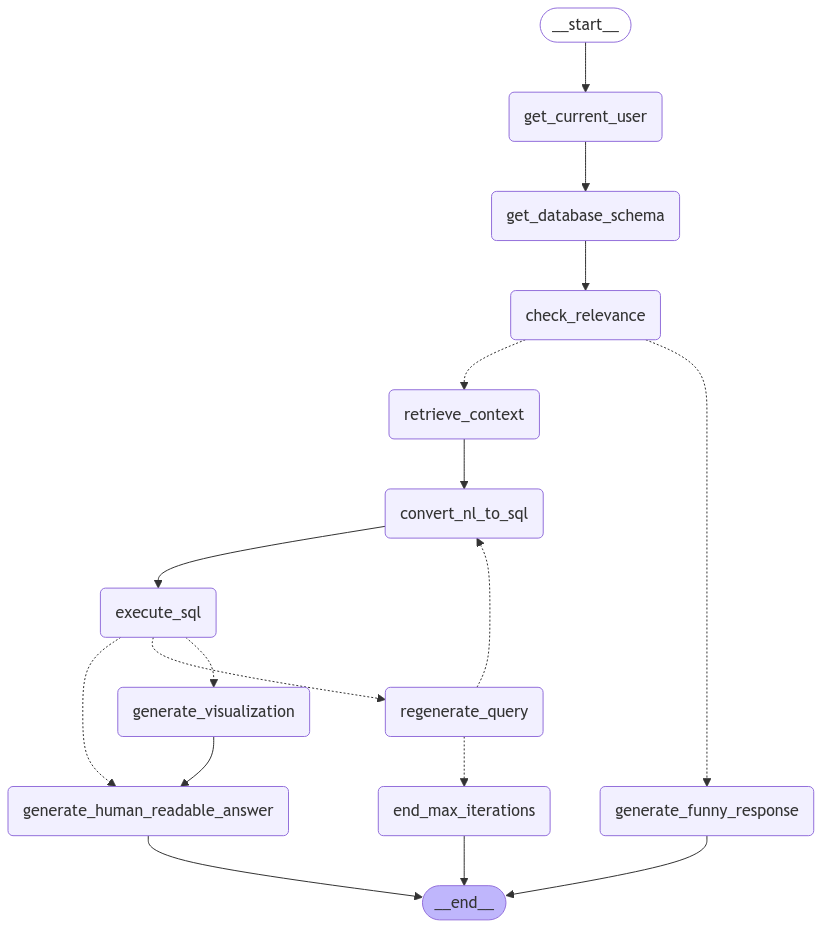

In [65]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [11]:
# save the graph
save_path = "workflow_graph.png"
graph = app.get_graph(xray=True).draw_mermaid_png()
with open(save_path, "wb") as f:
    f.write(graph)

In [38]:
fake_config = {"configurable": {"current_user_id": "5"},"recursion_limit": 50}

In [39]:
def get_orders_for_user(user_id: int):
    session = SessionLocal()
    try:
        orders = (
            session.query(Order)
            .join(Food, Order.food_id == Food.id)
            .filter(Order.user_id == user_id)
            .all()
        )
        if not orders:
            print(f"No orders found for user_id {user_id}.")
            return []

        order_list = []
        for order in orders:
            order_info = {
                "order_id": order.id,
                "food_name": order.food.name,
                "price": order.food.price
            }
            order_list.append(order_info)

        return order_list
    except Exception as e:
        print(f"Error retrieving orders for user_id {user_id}: {e}")
        return []
    finally:
        session.close()

orders = get_orders_for_user(5)
orders

[{'order_id': 8, 'food_name': 'Street_229709', 'price': 1000.07},
 {'order_id': 54, 'food_name': 'Spaghetti Carbonara', 'price': 41.81},
 {'order_id': 55, 'food_name': 'Spaghetti Carbonara', 'price': 41.81}]

In [104]:
user_question_1 = "show me all coupons and their discount, sort them by discount and use a nice chart to visualize the data"
result_1 = app.invoke({"question": user_question_1, **fake_config})
print(result_1["query_result"])


Retrieving the current user based on user ID.
No user ID provided in the configuration.
[DEBUG] Generated database description: The database is designed to manage a comprehensive restaurant or food service operation, encompassing various aspects such as promotions, food inventory, customer interactions, and financial transactions. The 'promotions', 'discounts', and 'coupons' tables likely work together to manage and track marketing efforts and special offers available to customers. The 'food' and 'ingredients' tables are essential for inventory management, detailing the menu items and their components, while the 'suppliers' table manages relationships with vendors providing these ingredients. Customer interactions are captured through the 'users', 'reservations', and 'reviews' tables, which store user information, booking details, and feedback, respectively. Financial transactions are handled by the 'payments' table, and employee information is managed in the 'employees' table. Lastly,

In [73]:
user_question_2 = "Tell me about most expensive food all over the world."
result_2 = app.invoke({"question": user_question_2, "attempts": 0}, config=fake_config)
print("Result:", result_2["query_result"])

Retrieving the current user based on user ID.
Current user set to: William Walton
[DEBUG] Generated database description: This database is designed to manage a food-related business, encompassing various aspects such as sales, promotions, and customer interactions. The core tables include 'food', which lists the available food items, and 'orders', which records customer purchases. The 'food_category' and 'food_category_mapping' tables help organize food items into categories, facilitating easier management and retrieval. Promotions and discounts are managed through the 'promotions' and 'discounts' tables, which can be linked to specific food items or categories to enhance sales strategies. Customer information and interactions are tracked in the 'users' and 'loyalty_program' tables, the latter of which incentivizes repeat business through rewards. Financial transactions are recorded in the 'payments' table, while 'vendors' and 'ingredients' tables manage supply chain aspects. Lastly, t

In [93]:
user_question_3 = "Find top 5 orders by price."
result_3 = app.invoke({"question": user_question_3, "attempts": 0}, config=fake_config)
print("Result:", result_3["query_result"])

Retrieving the current user based on user ID.
Current user set to: William Walton
[DEBUG] Generated database description: The database is designed to manage a food-related business, encompassing various aspects such as food items, orders, payments, and customer interactions. The 'food' table likely stores information about individual food items, which are categorized using the 'food_category' and 'food_category_mapping' tables, allowing for organized classification and retrieval of food data. The 'recipes' table provides detailed information about how each food item is prepared, potentially linking to the 'food' table to specify which items are included in each recipe.

The 'orders' table records customer orders, which are associated with the 'payments' table to track financial transactions related to these orders. The 'coupons' table is used to manage promotional discounts that can be applied to orders, enhancing customer engagement and sales. Finally, the 'reviews' table captures cus

In [81]:
user_question_1 = '''Show me top 5 most cheap foods and their prices, use hist plot to visualize it.'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])


Retrieving the current user based on user ID.
Current user set to: William Walton
[DEBUG] Generated database description: The database is designed to manage a comprehensive food service operation, encompassing various aspects such as promotions, food offerings, customer interactions, and vendor relationships. The 'promotions' table likely stores information about marketing campaigns and special offers, which may be linked to specific food items in the 'food' table. The 'discounts' table complements this by detailing any price reductions available to customers. Customer data is managed in the 'users' table, which could be associated with the 'loyalty_program' table to track and reward frequent patrons. 

The 'ingredients' table provides details on the components of each food item, potentially linking to the 'food' table to ensure accurate inventory and recipe management. Vendor relationships are managed through the 'vendors' table, which might be connected to the 'ingredients' table to 

In [76]:
user_question_1 = '''Show me top 5 users who has highest points, and use a pie chart.'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])


Retrieving the current user based on user ID.
Current user set to: William Walton
[DEBUG] Generated database description: The database is designed to manage a comprehensive food service operation, encompassing various aspects such as inventory, customer management, and financial transactions. The 'food' table likely stores information about the menu items, while the 'food_category' table categorizes these items, facilitating organization and retrieval. Customer-related data is managed through the 'users' table, which may include personal details, and the 'loyalty_program' table, which tracks customer engagement and rewards. Financial transactions are recorded in the 'payments' table, ensuring accurate billing and payment processing.

The 'suppliers' table is crucial for managing relationships with vendors who provide the ingredients or products needed for the food service. Employee information is stored in the 'employees' table, which may include roles and contact details, supporting w

In [49]:
user_question_1 = '''Show me average Salary by position'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])


Retrieving the current user based on user ID.
Current user set to: William Walton
[DEBUG] Retrieved schema info successfully: ### Relevant Schema Information

Table: inventory
  - id (INTEGER) -  Examples: 1, 2, 3
  - ingredient_id (INTEGER) -  Examples: 1, 4, 6
  - stock_level (FLOAT) [RELEVANT] -  Examples: 60.46, 97.53, 55.17

Table: food
  - id (INTEGER) -  Examples: 16, 10, 15
  - name (VARCHAR) [RELEVANT] -  Examples: American_439021, Bill_487497, Democrat_553905
  - price (FLOAT) [RELEVANT] -  Examples: 41.81, 3.65, 2.91

Table: users
  - id (INTEGER) -  Examples: 21, 6, 14
  - name (VARCHAR) [RELEVANT] -  Examples: Adam Liu, Adam Owens, Alice
  - age (INTEGER) -  Examples: 21, 43, 31
  - email (VARCHAR) -  Examples: alice@example.com, apham@example.org, baldwinpaul@example.com

Table: ingredients
  - id (INTEGER) -  Examples: None
  - name (VARCHAR) [RELEVANT] -  Examples: None
  - cost_per_unit (FLOAT) [RELEVANT] -  Examples: None

Table: payments
  - id (INTEGER) -  Examples:

In [85]:
user_question_1 = '''Plot a histogram of order values.'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])


Retrieving the current user based on user ID.
Current user set to: William Walton
[DEBUG] Generated database description: The database is designed to manage a comprehensive food service operation, encompassing various aspects such as promotions, food inventory, user management, and supplier coordination. The 'promotions' table likely stores information about marketing campaigns and discounts, while the 'coupons' table may contain specific discount codes and their details. The 'food' table, along with the 'food_category_mapping' table, manages the inventory and categorization of food items, possibly linking them to specific suppliers listed in the 'suppliers' table. User interactions are captured in the 'users' table, which may be linked to the 'loyalty_program' table to track customer rewards and incentives. Financial transactions are recorded in the 'payments' table, and employee work schedules are managed in the 'schedules' table. Finally, customer feedback and ratings are stored in 

In [105]:
user_question_1 = ''' Analyze food's discount percentage, and show it in a pie chart.'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])


Retrieving the current user based on user ID.
Current user set to: William Walton
Retrieved database schema.
Database schema: Table: coupons
- id: INTEGER, Primary Key
- code: VARCHAR
- discount_percentage: FLOAT
- expiration_date: DATE

Table: discounts
- id: INTEGER, Primary Key
- food_id: INTEGER
- discount_percentage: FLOAT

Table: employees
- id: INTEGER, Primary Key
- name: VARCHAR
- position: VARCHAR
- salary: FLOAT

Table: food
- id: INTEGER, Primary Key
- name: VARCHAR
- price: FLOAT

Table: food_category
- id: INTEGER, Primary Key
- name: VARCHAR

Table: food_category_mapping
- id: INTEGER, Primary Key
- food_id: INTEGER
- category_id: INTEGER

Table: ingredients
- id: INTEGER, Primary Key
- name: VARCHAR
- cost_per_unit: FLOAT

Table: inventory
- id: INTEGER, Primary Key
- ingredient_id: INTEGER
- stock_level: FLOAT

Table: loyalty_program
- id: INTEGER, Primary Key
- user_id: INTEGER
- points: INTEGER
- membership_tier: VARCHAR

Table: orders
- id: INTEGER, Primary Key
- fo

In [86]:
user_question_1 = ''' Show a scatter plot of price vs. discount percentage for food items..'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])

Retrieving the current user based on user ID.
Current user set to: William Walton
[DEBUG] Generated database description: This database appears to be designed for a food-related business, possibly a restaurant or a food delivery service, with a focus on managing promotions, food items, and customer interactions. The 'promotions', 'discounts', and 'coupons' tables likely handle various marketing strategies to attract and retain customers, each containing details pertinent to their respective promotional types. The 'food', 'ingredients', and 'food_category' tables are central to managing the menu, with 'food_category_mapping' linking food items to their respective categories, ensuring organized and efficient menu management. The 'users' and 'reviews' tables are crucial for customer relationship management, capturing user information and feedback, which can be used to enhance service quality. Additionally, the 'payments' table manages financial transactions, while the 'suppliers' table li

<Figure size 1000x600 with 0 Axes>

In [52]:
user_question_1 = '''Find all ordered food catogorized them, count total price of orders by category, 
and show it in a bar chart. hilight minimum and maximum value with different color.'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])


Retrieving the current user based on user ID.
Current user set to: William Walton
[DEBUG] Retrieved schema info successfully: ### Relevant Schema Information

Table: food
  - id (INTEGER) -  Examples: 16, 10, 15
  - name (VARCHAR) -  Examples: American_439021, Bill_487497, Democrat_553905
  - price (FLOAT) [RELEVANT] -  Examples: 41.81, 3.65, 2.91

Table: discounts
  - id (INTEGER) -  Examples: 1, 2, 3
  - food_id (INTEGER) [RELEVANT] -  Examples: 1, 4, 4
  - discount_percentage (FLOAT) -  Examples: 20.0, 10.0, 12.0

Table: ingredients
  - id (INTEGER) -  Examples: None
  - name (VARCHAR) -  Examples: None
  - cost_per_unit (FLOAT) [RELEVANT] -  Examples: None

Table: payments
  - id (INTEGER) -  Examples: 1, 2, 3
  - order_id (INTEGER) [RELEVANT] -  Examples: 12, 25, 37
  - amount_paid (FLOAT) [RELEVANT] -  Examples: 50.28, 49.95, 81.57
  - payment_date (DATE) [RELEVANT] -  Examples: 2025-01-12, 2025-01-06, 2025-01-07

Table: suppliers
  - id (INTEGER) -  Examples: 2, 1
  - name (VARC